# Autoencoder,   anomaly detection

An autoencoder is a neural net that compresses the dimensionality of the data, then expands the data back to the original number of dimensions.

It is trained on "normal data",  where the reconstruction should be pretty good quality.

When we use it on anomalous data, it should not peform as well on the anomalous data,   the reconstruction error should be higher.

Notice that this is very much like the approach used with the PCA based detection of anomalies,  it relies on reducing the dimensions, then re-expanding the data to spot errors in the
reconstruction.

See

https://www.tensorflow.org/tutorials/generative/autoencoder

Checked in Google Colab,   1/18/2023

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

The data set is ECG data, these are 140 step time series, with a label of normal or anomalous

We will load the data, split it, and then train only on the normal data.

In [23]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [24]:
# how many entries do we have

dataframe.shape

(4998, 141)

In [25]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [26]:
print(sum(labels==1))
print(sum(labels==0))

2919
2079


Rescale the data into the range 0 to 1

Convert it to tensorflow data,  32 bit float

Tensor flow has it's own data types- storage control

Note the scaling uisng only the range of the train data, not test data

In [27]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Split into normal and anomalous data sets

In [28]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a couple of normal and anomalous ECG patterns

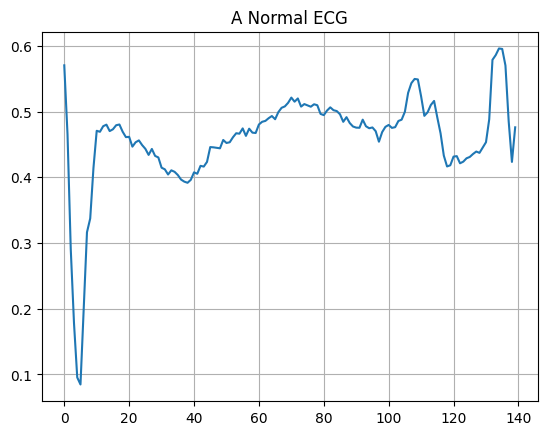

In [29]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

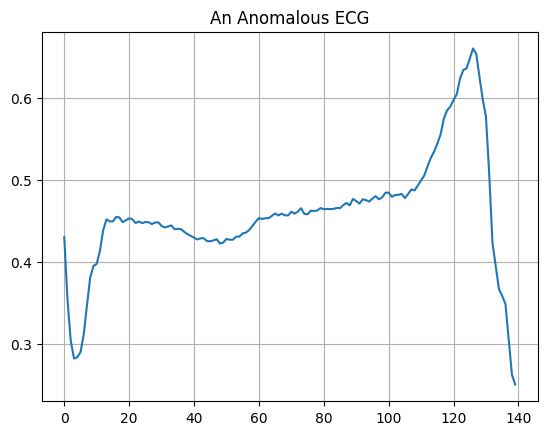

In [30]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Create the Anomaly detector

It has a two step model,  an encode and a decoder

Note the use of the sigmoid output on the last layer of the decoder, to produce the range from zero to 1

In [31]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [32]:
autoencoder.compile(optimizer='adam', loss='mae')

Note that in the validation, both the normal and anomalous data are used

The loss is the mae

In [33]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 3s 71ms/step - loss: 0.0589 - val_loss: 0.0536
Epoch 2/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0567 - val_loss: 0.0524
Epoch 3/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0552 - val_loss: 0.0511
Epoch 4/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0532 - val_loss: 0.0495
Epoch 5/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0502 - val_loss: 0.0481
Epoch 6/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0466 - val_loss: 0.0473
Epoch 7/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0429 - val_loss: 0.0453
Epoch 8/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0389 - val_loss: 0.0428
Epoch 9/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0355 - val_loss: 0.0415
Epoch 10/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0328 - val_loss: 0.0403
Epoch 11/20
5/5 [============

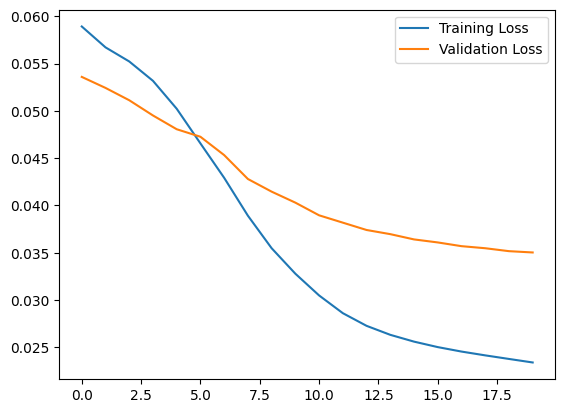

In [34]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### Now we can encode the data with a call to autoencoder.encoder()
and then reconvert it to the regular representation with the decoder

Then, we can plot the two to see the error in the reconstruction

We expect the autoencoder to do a beter job at re-encoding the normal data than the anomalous data

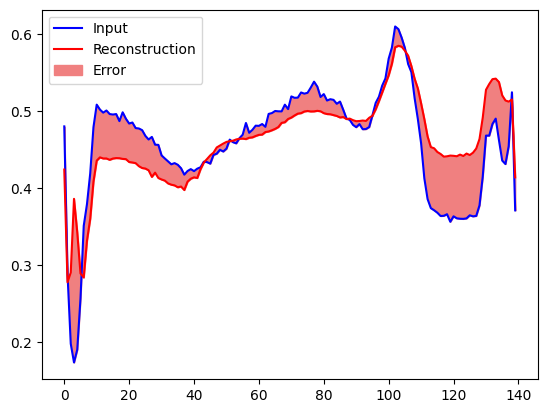

In [35]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

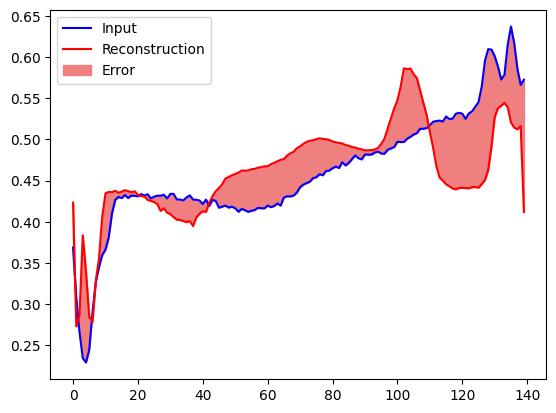

In [36]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

74/74 [==============================] - 0s 2ms/step


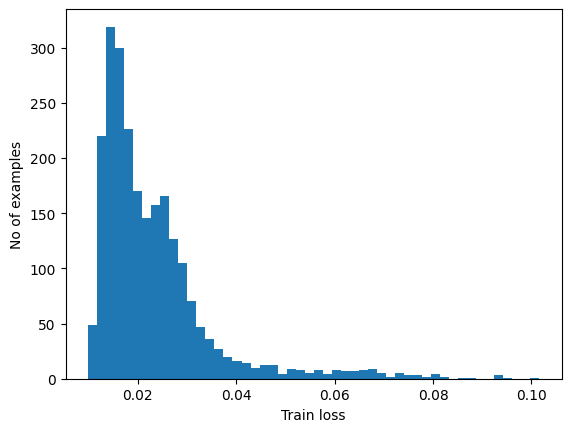

In [37]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [38]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.0351792


14/14 [==============================] - 0s 2ms/step


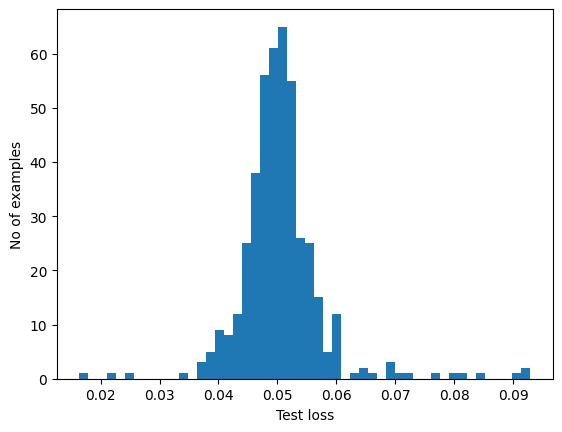

In [39]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


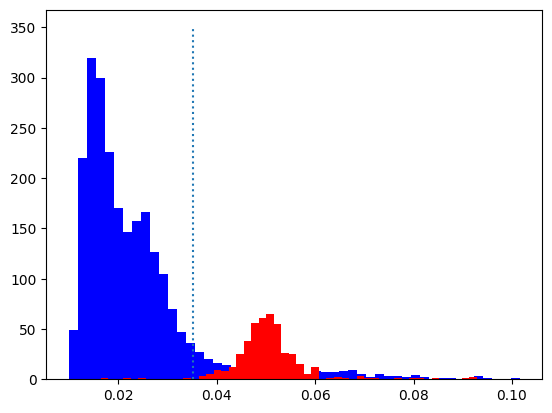

In [40]:
plt.hist(train_loss[None,:], bins=50,color="blue")

plt.hist(test_loss[None, :], bins=50,color='red')

plt.plot([threshold,threshold],[0,350],linestyle=":")

In [41]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [42]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.946
Precision = 0.9922178988326849
Recall = 0.9107142857142857
